In [1]:
import os
os.chdir('../')

In [2]:
import io

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import torch
from IPython.display import display
from ipywidgets import HBox
from ipywidgets import Image as ImageWidget
from ipywidgets import Layout, Output
from PIL import Image
from sklearn.manifold import TSNE

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
sample_concept = concept_instances['random continuous']
sample_concept.prepare_data(env_steps, max_size=10000)
test_images = sample_concept.test_images
test_obs = sample_concept.test_obs

In [4]:
model_path = QNetwork.find_newest_model()
model = QNetwork(frame_stacks=1, model_path=model_path)
layer = 7
print(f"Using model: {model_path} at layer: {layer}")

q_values, test_acts_dict = model(torch.tensor(test_obs), return_acts=True)
q_values = q_values.cpu().detach().numpy().mean(axis=1)
test_acts = test_acts_dict[layer].cpu().detach().numpy()
test_acts = test_acts.reshape(test_acts.shape[0], -1)

Using model: runs/20240224-103820_task_0/model_10000000.pt at layer: 7


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.295s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.868088
[t-SNE] KL divergence after 1000 iterations: 0.998815


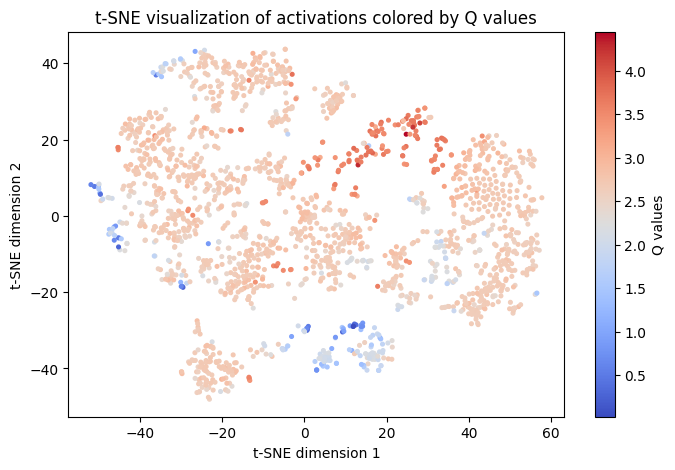

In [5]:
tsne = TSNE(n_components=2, verbose=1)#, perplexity=50)#, early_exaggeration=50)
test_acts_2d = tsne.fit_transform(test_acts)

# Visualizing the activations colored by the corresponding q_values
plt.figure(figsize=(8, 5))
scatter = plt.scatter(test_acts_2d[:, 0], test_acts_2d[:, 1], c=q_values, cmap='coolwarm', s=7)
plt.colorbar(scatter, label='Q values')
plt.title('t-SNE visualization of activations colored by Q values')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [6]:
coolwarm_scale = [
    [0.0, '#3b4cc0'],  # Cool (blue)
    [0.5, '#ffffff'],  # Midpoint (white)
    [1.0, '#d50426'],  # Warm (red)
]
# Set negative q values to 0
q_values = np.maximum(q_values, 0)

def img_to_displayable(img):
    img_pil = Image.fromarray(img)
    buff = io.BytesIO()
    img_pil.save(buff, format="PNG")
    return buff.getvalue()

# Create a scatter plot
fig = go.FigureWidget(
    data=px.scatter(x=test_acts_2d[:, 0], y=test_acts_2d[:, 1], color=q_values, color_continuous_scale=coolwarm_scale)
    .update_traces(marker=dict(size=7, opacity=0.8)).update_layout(width=800, height=500))
output_image = Output()

# Function to be called on hover
def on_hover(trace, points, state):
    with output_image:
        output_image.clear_output()
        if points.point_inds:
            ind = points.point_inds[0]
            img_data = img_to_displayable(test_images[ind])
            display(ImageWidget(value=img_data, format='png', width=300, height=300))

fig.data[0].on_hover(on_hover)

hbox_layout = HBox([fig, output_image], layout=Layout(align_items='center'))
display(hbox_layout)

    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<br>color=%{marker.color}<extra>…